In [ ]:
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.layers import BatchNormalization ,Dropout
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.utils import np_utils
from keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.utils import class_weight
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3  
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
import glob
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import skimage
from skimage.transform import resize
import time




imageSize=240



In [ ]:
#Import and shape image data (Auto)****************************************

import skimage
my_dict={"A":["H0","P0","V0"],"B":["H25","V25"],"C":["P25"],"D":["H50","V50"],"E":["P50"]}
images = []


# loop over the indexes of the houses
for key, value  in my_dict.items():
  inputPath='/tmp/Images_all/{}'.format(key)

  for val in value:
    for i in range(3,349):

        basePath = os.path.sep.join([inputPath, "{}_{}.tif".format(val,i)])
        housePath = sorted(list(glob.glob(basePath)))

        inputImages = []
        outputImage = np.zeros((120, 120, 3), dtype="uint8")

        image = cv2.imread(housePath[0])
        image= skimage.transform.resize(image, (120, 120,1))
        #convert image shape to RGB
        image=np.dstack([image] * 3)

        # if i==25:
        #   plotHistogram(image)




        img_arr = np.asarray(image)

        images.append(img_arr)


        # outputImage[0:120, 0:120] = inputImages[0]

        # images.append(outputImage)

        
        


CNN_image=np.asarray(images)
CNN_image.shape



def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);


In [1]:
#Import and shape MLP data
from sklearn import preprocessing
# data = pd.read_csv("/content/drive/My Drive/3.csv")
# X=data[['entropy_value','pixel_mean','pixel_std']]


data = pd.read_csv("/content/drive/My Drive/5.csv")
X = data.drop(["num", "layer_order", "layer_name","Response"], axis=1)
coulumn_name=list(X)


X_MLP = preprocessing.scale(X)
# X_MLP= pd.DataFrame(X_MLP,columns=['entropy_value','pixel_mean','pixel_std'])
X_MLP= pd.DataFrame(X_MLP,columns=coulumn_name)




Y=np.array(data['Response'])

yy=[]
for i in Y:
    if i=='A':
        yy.append(0)
    elif i=='B':
        yy.append(1)
    elif i=="C":
        yy.append(2)
    elif i=='D':
        yy.append(3)
    elif i=='E':
        yy.append(4)


Y_MLP=np.array(yy)
Y_MLP =Y_MLP.reshape((Y_MLP.shape[0], 1))


X_MLP['Response']=Y_MLP
xy_MLP=X_MLP

xy_MLP.head()


In [2]:


labels = {0: 'A',  1: 'B', 2: 'C', 3: 'D', 4: 'E'}
dict_characters=labels
import seaborn as sns
df = pd.DataFrame()
df["labels"]=Y
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [ ]:

target_size = (120, 120)
target_dims = (120, 120,3) # add channel for RGB
number_classes=5
number_MLP_feature=3
number_epoch=200
batch_size=64
number_fold=6
# optimizer = keras.optimizers.Adam(lr=0.001)
# optimizer2 = keras.optimizers.RMSprop(lr=0.0001)



In [ ]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

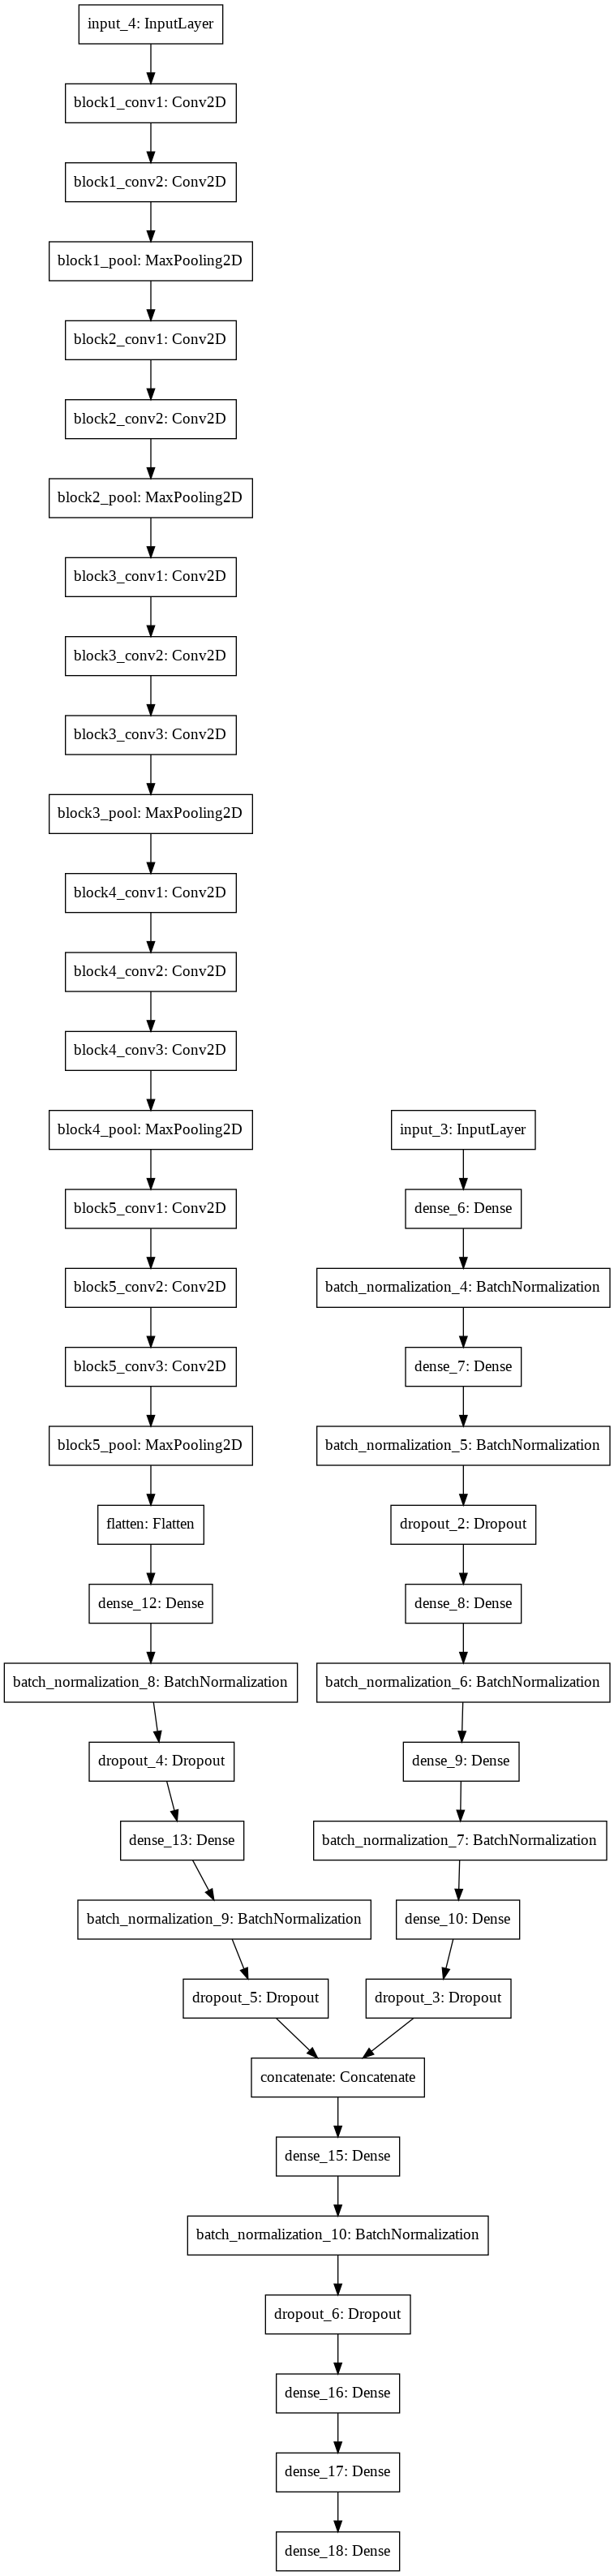

In [ ]:
#Cross validation
#just changed the confmatrix formula 

def Hybrid_model():
 
 
  #Create MLP
  input_MLP = Input(shape=(15,))
  # the first branch operates on the first input
  MLP = Dense(128, activation="relu")(input_MLP)
  MLP=BatchNormalization()(MLP)
  MLP = Dense(128, activation="relu")(MLP)
  MLP=BatchNormalization()(MLP)
  MLP= Dropout(0.5)(MLP)
  MLP = Dense(128, activation="relu")(MLP)
  MLP=BatchNormalization()(MLP)
  MLP = Dense(128, activation="relu")(MLP)
  MLP=BatchNormalization()(MLP)

  MLP = Dense(128, activation="relu")(MLP)
  MLP= Dropout(0.5)(MLP)

  output_MLP = Dense(number_classes, activation='softmax')(MLP)

  model_MLP = Model(inputs=input_MLP, outputs=output_MLP)



  #for merging
  model_MLP = Model(inputs=input_MLP, outputs=MLP)



  # model_MLP.summary()



  #create VGG


  from keras.applications.vgg16 import VGG16
  class_weight1 = class_weight.compute_class_weight('balanced', np.unique(y_non_trainHot), y_non_trainHot)

  #weight_path2 = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
  pretrained_model_1 = VGG16(weights = 'imagenet', include_top=False, input_shape=target_dims)
  #pretrained_model_2 = InceptionV3(weights = weight_path2, include_top=False, input_shape=(imageSize, imageSize, 3))
  # optimizer = keras.optimizers.Adam(lr=0.001)
  optimizer = keras.optimizers.RMSprop(lr=0.001)





  base_model = pretrained_model_1 # Topless
  # Train top layer
  for layer in base_model.layers:
      layer.trainable = False

  # Add top layer
  x = base_model.output
  x = Flatten()(x)

  x = Dense(128, activation="relu")(x)
  x=BatchNormalization()(x)
  x= Dropout(0.8)(x)


  x = Dense(128, activation="relu")(x)
  x=BatchNormalization()(x)
  x= Dropout(0.5)(x)



  predictions = Dense(5, activation='softmax')(x)
  # VGG_model = Model(inputs=base_model.input, outputs=predictions)

  # for merge

  VGG_model = Model(inputs=base_model.input, outputs=x)






  combinedInput = concatenate([model_MLP.output, VGG_model.output])




  x = Dense(128, activation="relu")(combinedInput)
  x=BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Dense(128, activation="relu")(x)
  # x=BatchNormalization()(x)
  # x = Dropout(0.5)(x)

  x = Dense(4, activation="relu")(x)
  x = Dense(number_classes, activation="softmax")(x)

  # The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
  model = Model(inputs=[model_MLP.input, VGG_model.input], outputs=x)

  # Compile the model 
  # Optimizer=keras.optimizers.RMSprop(lr=0.0001)
  # Optimizer=keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)


  
  return model







Optimizer=keras.optimizers.Adam(lr=0.0001)
Optimizer= keras.optimizers.RMSprop(lr=0.001)




from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy





(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(xy_MLP, CNN_image, test_size=0.20,random_state=1375)


trainY = trainAttrX["Response"] 
testY = testAttrX["Response"]

trainAttrX=np.array(trainAttrX.drop((['Response']),axis=1))
testAttrX=np.array(testAttrX.drop((['Response']),axis=1))




#one hot encoding



#concatenate images

XX_mlp_all=np.append(trainAttrX, testAttrX, axis=0)
XX_CNN_all=np.append(trainImagesX, testImagesX, axis=0)
YY_all=np.append(trainY, testY, axis=0)










cvscores = []


# using fromkeys() to construct 
train_ft = list()
test_ft = list()


fold_number=0
for train_index,test_index in KFold(number_fold, shuffle=True,random_state=1375).split(XX_mlp_all):
  fold_number+=1
  
  start_time_train_ft=time.perf_counter()


  trainAttrX=XX_mlp_all[train_index] 
  trainImagesX=XX_CNN_all[train_index]

  testAttrX=XX_mlp_all[test_index] 
  testImagesX=XX_CNN_all[test_index]



  y_non_trainHot=YY_all[train_index]
  y_non_testhot=YY_all[test_index]

  from keras.utils.np_utils import to_categorical
  y_trainHot= keras.utils.to_categorical(y_non_trainHot, num_classes=number_classes)
  y_testhot = keras.utils.to_categorical(y_non_testhot, num_classes=number_classes)


  class_weight1 = class_weight.compute_class_weight('balanced', np.unique(y_non_trainHot), y_non_trainHot)
 
  model=Hybrid_model()
  # model.summary()
  # plot_model(model)




  model.compile(loss='categorical_crossentropy',optimizer=Optimizer,metrics=['accuracy'])






  filepath='/content/drive/My Drive/Colab Notebooks/Penn/MS_TH/Model/thesis_{}fold_fold_{}.h5'.format(number_fold,fold_number)
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=False)
  callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, verbose=2),checkpoint]







  
  history=model.fit([trainAttrX, trainImagesX], y_trainHot,
	validation_data=([testAttrX, testImagesX], y_testhot),
	epochs=300, batch_size=batch_size,callbacks = callbacks_list,verbose=1)

  finish_time_train_ft=time.perf_counter()


  train_ft.append(finish_time_train_ft-start_time_train_ft)





  


  labels = {0: 'A',  1: 'B', 2: 'C', 3: 'D', 4: 'E'}

  print('****** Train set evaluation .....\n ')
  score = model.evaluate([trainAttrX, trainImagesX],y_trainHot, verbose=0)
  print('\nKeras CNN - accuracy:', score[1], '\n')
  y_pred = model.predict([trainAttrX, trainImagesX])
  confusion_mtx=confusion_matrix(y_non_trainHot, np.argmax(y_pred, axis=1))
  print(classification_report(y_non_trainHot, np.argmax(y_pred, axis=1)))



  plt.show()
  plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
  plt.show()







  print('****** Test set evaluation .....\n ')
  # Evaluate model on train data
  scores = model.evaluate([testAttrX, testImagesX], y_testhot, verbose=0)
  print('\nKeras CNN - accuracy:', scores[1], '\n')
  y_pred = model.predict([testAttrX, testImagesX])
  confusion_mtx=confusion_matrix(y_non_testhot, np.argmax(y_pred, axis=1))
  print(classification_report(y_non_testhot, np.argmax(y_pred, axis=1)))



  start_time_test_ft=time.perf_counter()
  y_pred = model.predict([testAttrX[1:2], testImagesX[1:2]])
  finish_time_test_ft=time.perf_counter()
  print(f"{finish_time_test_ft-start_time_test_ft:0.4f}")

  
  test_ft.append(finish_time_test_ft-start_time_test_ft)

  
  
  plt.show()
  plot_learning_curve(history)
  plt.show()
  plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
  
  plt.show()









  cvscores.append(scores[1] * 100)


print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

print("average of train time ={0:.4g}".format(sum(train_ft)/len(train_ft)),"'\n average of test time ={0:.4g}".format(sum(test_ft)/len(test_ft)))




